# Third Test

This time we have a more robust auto regressive implemenation, because now I understand the attention masking. Both full and causal.

In [ ]:
from huggingface_hub import login
login()

In [ ]:
#!uv pip uninstall -q transformers
!uv pip install "git+https://github.com/huggingface/transformers.git@fix/lerobot_openpi" "lerobot @ git+https://github.com/huggingface/lerobot.git" opencv-python

Using Python 3.12.12 environment at: /usr
Resolved 109 packages in 1.40s
Installed 1 package in 44ms
 + transformers==4.53.3 (from git+https://github.com/huggingface/transformers.git@dcddb970176382c0fcf4521b0c0e6fc15894dfe0)


We have several problem trying to use the transformers library, this requires a more careful study

In [ ]:
import builtins
import logging
import math
from collections import deque
from pathlib import Path
from typing import TYPE_CHECKING, Literal, TypedDict

import torch
import torch.nn.functional as F  # noqa: N812
from torch import Tensor, nn
from typing_extensions import Unpack

from lerobot.utils.import_utils import _transformers_available

# Conditional import for type checking and lazy loading
if TYPE_CHECKING or _transformers_available:
    from transformers.models.auto import CONFIG_MAPPING
    from transformers.models.gemma import modeling_gemma
    from transformers.models.gemma.modeling_gemma import GemmaForCausalLM
    from transformers.models.paligemma.modeling_paligemma import (
        PaliGemmaForConditionalGeneration,
    )
else:
    CONFIG_MAPPING = None
    modeling_gemma = None
    GemmaForCausalLM = None
    PaliGemmaForConditionalGeneration = None

from lerobot.configs.policies import PreTrainedConfig
from lerobot.policies.pi05.configuration_pi05 import PI05Config
from lerobot.policies.pretrained import PreTrainedPolicy, T
from lerobot.policies.rtc.modeling_rtc import RTCProcessor
from lerobot.utils.constants import (
    ACTION,
    OBS_LANGUAGE_ATTENTION_MASK,
    OBS_LANGUAGE_TOKENS,
    OPENPI_ATTENTION_MASK_VALUE,
)


class ActionSelectKwargs(TypedDict, total=False):
    inference_delay: int | None
    prev_chunk_left_over: Tensor | None
    execution_horizon: int | None


def get_safe_dtype(target_dtype, device_type):
    """Get a safe dtype for the given device type."""
    if device_type == "mps" and target_dtype == torch.float64:
        return torch.float32
    if device_type == "cpu":
        # CPU doesn't support bfloat16, use float32 instead
        if target_dtype == torch.bfloat16:
            return torch.float32
        if target_dtype == torch.float64:
            return torch.float64
    return target_dtype


# Positional Embedding for time action embedding
def create_sinusoidal_pos_embedding(
    time: torch.Tensor, dimension: int,
    min_period: float, max_period: float, device="cpu"
) -> Tensor:
    """Computes sine-cosine positional embedding
    vectors for scalar positions."""
    if dimension % 2 != 0:
        raise ValueError(f"dimension ({dimension}) must be divisible by 2")

    if time.ndim != 1:
        raise ValueError("The time tensor is expected " +
                         "to be of shape `(batch_size, )`.")

    dtype = get_safe_dtype(torch.float64, device.type)
    fraction = torch.linspace(0.0, 1.0, dimension // 2,
                              dtype=dtype, device=device)
    period = min_period * (max_period / min_period) ** fraction

    # Compute the outer product
    scaling_factor = 1.0 / period * 2 * math.pi
    sin_input = scaling_factor[None, :] * time[:, None]
    return torch.cat([torch.sin(sin_input), torch.cos(sin_input)], dim=1)


# For training
def sample_beta(alpha, beta, bsize, device):
    alpha_t = torch.as_tensor(alpha, dtype=torch.float32, device=device)
    beta_t = torch.as_tensor(beta, dtype=torch.float32, device=device)
    dist = torch.distributions.Beta(alpha_t, beta_t)
    return dist.sample((bsize,))


def make_att_2d_masks(pad_masks, att_masks):
    """
    Tokens can attend to valid inputs tokens which have a cumulative mask_ar
    smaller or equal to theirs. This way `mask_ar` int[B, N] can be used to
    setup several types of attention, for example:

      [[1 1 1 1 1 1]]: pure causal attention.

      [[0 0 0 1 1 1]]: prefix-lm attention. The first 3 tokens can attend
        between
          themselves and the last 3 tokens have a causal attention. The first
          entry could also be a 1 without changing behaviour.

      [[1 0 1 0 1 0 0 1 0 0]]: causal attention between 4 blocks. Tokens of a
          block can attend all previous blocks and all
          tokens on the same block.

    Args:
        N: int - number of tokens in the sequence
        pad_masks: bool[B, N] true if its part of the input,
            false if padding.
        att_masks: int[B, N] mask that's 1 where previous tokens
            cannot depend on it and 0 where it shares the same
            attention mask as the previous token.

    Returns:
        att_2d_masks: bool[B, N, N] 2D attention mask
    """
    if att_masks.ndim != 2:
        raise ValueError(att_masks.ndim)
    if pad_masks.ndim != 2:
        raise ValueError(pad_masks.ndim)

    # cumsum shape: (B, N)
    cumsum = torch.cumsum(att_masks, dim=1)
    # att_2d_masks shape: (B, N, N)
    att_2d_masks = cumsum[:, None, :] <= cumsum[:, :, None]
    # pad_2d_masks shape: (B, N, N)
    pad_2d_masks = pad_masks[:, None, :] * pad_masks[:, :, None]
    # att_2d_masks & pad_2d_masks shape: (B, N, N)
    return att_2d_masks & pad_2d_masks


def pad_vector(vector, new_dim):
    """Pad the last dimension of a vector to new_dim with zeros.

    Can be (batch_size x sequence_length x features_dimension)
    or (batch_size x features_dimension)
    """
    if vector.shape[-1] >= new_dim:
        return vector
    return F.pad(vector, (0, new_dim - vector.shape[-1]))


def resize_with_pad_torch(
    images: torch.Tensor,
    height: int,
    width: int,
    mode: str = "bilinear",
) -> torch.Tensor:
    """PyTorch version of resize_with_pad. Resizes an image
      to a target height and width without distortion
    by padding with black. If the image is float32,
      it must be in the range [-1, 1].

    Args:
        images: Tensor of shape [*b, h, w, c] or [*b, c, h, w]
        height: Target height
        width: Target width
        mode: Interpolation mode ('bilinear', 'nearest', etc.)

    Returns:
        Resized and padded tensor with same shape format as input
    """
    # Check if input is in channels-last format
    # [*b, h, w, c] or channels-first [*b, c, h, w]
    if images.shape[-1] <= 4:  # Assume channels-last format
        channels_last = True
        if images.dim() == 3:
            images = images.unsqueeze(0)  # Add batch dimension
        images = images.permute(0, 3, 1, 2)  # [b, h, w, c] -> [b, c, h, w]
    else:
        channels_last = False
        if images.dim() == 3:
            images = images.unsqueeze(0)  # Add batch dimension

    batch_size, channels, cur_height, cur_width = images.shape

    # Calculate resize ratio
    ratio = max(cur_width / width, cur_height / height)
    resized_height = int(cur_height / ratio)
    resized_width = int(cur_width / ratio)

    # Resize
    resized_images = F.interpolate(
        images,
        size=(resized_height, resized_width),
        mode=mode,
        align_corners=False if mode == "bilinear" else None,
    )

    # Handle dtype-specific clipping
    if images.dtype == torch.uint8:
        resized_images = torch.round(resized_images)
        resized_images = resized_images.clamp(0, 255).to(torch.uint8)
    elif images.dtype == torch.float32:
        resized_images = resized_images.clamp(-1.0, 1.0)
    else:
        raise ValueError(f"Unsupported image dtype: {images.dtype}")

    # Calculate padding
    pad_h0, remainder_h = divmod(height - resized_height, 2)
    pad_h1 = pad_h0 + remainder_h
    pad_w0, remainder_w = divmod(width - resized_width, 2)
    pad_w1 = pad_w0 + remainder_w

    # Pad
    constant_value = 0 if images.dtype == torch.uint8 else -1.0
    padded_images = F.pad(
        resized_images,
        (pad_w0, pad_w1, pad_h0, pad_h1),  # left, right, top, bottom
        mode="constant",
        value=constant_value,
    )

    # Convert back to original format if needed
    if channels_last:
        # [b, c, h, w] -> [b, h, w, c]
        padded_images = padded_images.permute(0, 2, 3, 1)

    return padded_images


# Define the complete layer computation function for gradient checkpointing
def compute_layer_complete(
    layer_idx, inputs_embeds, attention_mask,
    position_ids, adarms_cond, paligemma, gemma_expert
):
    models = [paligemma.language_model, gemma_expert.model]
    query_states = []
    key_states = []
    value_states = []
    gates = []
    for i, hidden_states in enumerate(inputs_embeds):
        layer = models[i].layers[layer_idx]
        hidden_states, gate = layer.input_layernorm(hidden_states,
                                                    cond=adarms_cond[i])
        gates.append(gate)
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, layer.self_attn.head_dim)
        query_state = layer.self_attn.q_proj(hidden_states)
        query_state = query_state.view(hidden_shape).transpose(1, 2)
        key_state = layer.self_attn.k_proj(hidden_states)
        key_state = key_state.view(hidden_shape).transpose(1, 2)
        value_state = layer.self_attn.v_proj(hidden_states)
        value_state = value_state.view(hidden_shape).transpose(1, 2)
        query_states.append(query_state)
        key_states.append(key_state)
        value_states.append(value_state)
    # Concatenate and process attention
    query_states = torch.cat(query_states, dim=2)
    key_states = torch.cat(key_states, dim=2)
    value_states = torch.cat(value_states, dim=2)
    dummy_tensor = torch.zeros(
        query_states.shape[0],
        query_states.shape[2],
        query_states.shape[-1],
        device=query_states.device,
        dtype=query_states.dtype,
    )
    cos, sin = paligemma.model.language_model.rotary_emb(dummy_tensor,
                                                         position_ids)
    query_states, key_states = modeling_gemma.apply_rotary_pos_emb(
        query_states, key_states, cos, sin, unsqueeze_dim=1
    )
    batch_size = query_states.shape[0]
    scaling = paligemma.language_model.layers[layer_idx].self_attn.scaling
    # Attention computation
    att_output, _ = modeling_gemma.eager_attention_forward(
        paligemma.language_model.layers[layer_idx].self_attn,
        query_states,
        key_states,
        value_states,
        attention_mask,
        scaling,
    )
    # Get head_dim from the current layer, not from the model
    head_dim = paligemma.language_model.layers[layer_idx].self_attn.head_dim
    att_output = att_output.reshape(batch_size, -1, 1 * 8 * head_dim)
    # Process layer outputs
    outputs_embeds = []
    start_pos = 0
    for i, hidden_states in enumerate(inputs_embeds):
        layer = models[i].layers[layer_idx]
        end_pos = start_pos + hidden_states.shape[1]
        if att_output.dtype != layer.self_attn.o_proj.weight.dtype:
            att_output = att_output.to(layer.self_attn.o_proj.weight.dtype)
        out_emb = layer.self_attn.o_proj(att_output[:, start_pos:end_pos])
        # first residual
        out_emb = modeling_gemma._gated_residual(hidden_states,
                                                 out_emb, gates[i])
        after_first_residual = out_emb.clone()
        out_emb, gate = layer.post_attention_layernorm(out_emb,
                                                       cond=adarms_cond[i])
        # Convert to bfloat16 if the next layer (mlp) uses bfloat16
        if layer.mlp.up_proj.weight.dtype == torch.bfloat16:
            out_emb = out_emb.to(dtype=torch.bfloat16)
        out_emb = layer.mlp(out_emb)
        # second residual
        out_emb = modeling_gemma._gated_residual(after_first_residual,
                                                 out_emb, gate)
        outputs_embeds.append(out_emb)
        start_pos = end_pos
    return outputs_embeds


class GemmaConfig:  # see openpi `gemma.py: Config`
    """Configuration for Gemma model variants."""

    def __init__(self, width, depth, mlp_dim,
                 num_heads, num_kv_heads, head_dim):
        self.width = width
        self.depth = depth
        self.mlp_dim = mlp_dim
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads
        self.head_dim = head_dim


def get_gemma_config(variant: str) -> GemmaConfig:
    """Returns config for specified gemma variant."""
    # This is the config for the action expert
    if variant == "gemma_300m":
        return GemmaConfig(
            width=1024,
            depth=18,
            mlp_dim=4096,
            num_heads=8,
            num_kv_heads=1,
            head_dim=256,
        )
    # Vison Language Config
    elif variant == "gemma_2b":
        return GemmaConfig(
            width=2048,
            depth=18,
            mlp_dim=16_384,
            num_heads=8,
            num_kv_heads=1,
            head_dim=256,
        )
    else:
        raise ValueError(f"Unknown variant: {variant}")


class PaliGemmaWithExpertModel(nn.Module):
    """PaliGemma model with action expert for PI05."""
    def __init__(
        self, vlm_config, action_expert_config, use_adarms=None,
        precision: Literal["bfloat16", "float32"] = "bfloat16",
    ):
        if use_adarms is None:
            use_adarms = [False, False]
        super().__init__()

        # Configuration from the VLM PALIGEMMA
        vlm_config_hf = CONFIG_MAPPING["paligemma"]()
        vlm_config_hf._vocab_size = 257152  # noqa: SLF001
        vlm_config_hf.image_token_index = 257152
        vlm_config_hf.text_config.hidden_size = vlm_config.width
        vlm_config_hf.text_config.intermediate_size = vlm_config.mlp_dim
        vlm_config_hf.text_config.num_attention_heads = vlm_config.num_heads
        vlm_config_hf.text_config.head_dim = vlm_config.head_dim
        vlm_config_hf.text_config.num_hidden_layers = vlm_config.depth
        vlm_config_hf.text_config.num_key_value_heads = vlm_config.num_kv_heads
        vlm_config_hf.text_config.hidden_activation = "gelu_pytorch_tanh"
        vlm_config_hf.text_config.torch_dtype = "float32"
        vlm_config_hf.text_config.vocab_size = 257152
        vlm_config_hf.text_config.use_adarms = use_adarms[0]
        vlm_config_hf.text_config.adarms_cond_dim = (
            vlm_config.width if use_adarms[0] else None
        )
        vlm_config_hf.vision_config.intermediate_size = 4304
        vlm_config_hf.vision_config.projection_dim = 2048
        vlm_config_hf.vision_config.projector_hidden_act = "gelu_fast"
        vlm_config_hf.vision_config.torch_dtype = "float32"

        # CONFIGURATION FOR THE ACTION EXPERT
        action_expert_config_hf = CONFIG_MAPPING["gemma"](
            head_dim=action_expert_config.head_dim,
            hidden_size=action_expert_config.width,
            intermediate_size=action_expert_config.mlp_dim,
            num_attention_heads=action_expert_config.num_heads,
            num_hidden_layers=action_expert_config.depth,
            num_key_value_heads=action_expert_config.num_kv_heads,
            vocab_size=257152,
            hidden_activation="gelu_pytorch_tanh",
            torch_dtype="float32",
            use_adarms=use_adarms[1],
            adarms_cond_dim=(
                action_expert_config.width if use_adarms[1] else None
            ),
        )
        # VLM
        self.paligemma = PaliGemmaForConditionalGeneration(
            config=vlm_config_hf)

        # Expert Architecture Initialized from a small Gemma Version
        # From pretrained only loads the paligemma model
        self.gemma_expert = GemmaForCausalLM(config=action_expert_config_hf)
        self.gemma_expert.model.embed_tokens = None

        self.to_bfloat16_for_selected_params(precision)

    def to_bfloat16_for_selected_params(
            self, precision: Literal["bfloat16", "float32"] = "bfloat16"):
        if precision == "bfloat16":
            self.to(dtype=torch.bfloat16)
        elif precision == "float32":
            self.to(dtype=torch.float32)
            return
        else:
            raise ValueError(f"Invalid precision: {precision}")

        params_to_keep_float32 = [
            "vision_tower.vision_model.embeddings.patch_embedding.weight",
            "vision_tower.vision_model.embeddings.patch_embedding.bias",
            "vision_tower.vision_model.embeddings.position_embedding.weight",
            "input_layernorm",
            "post_attention_layernorm",
            "model.norm",
        ]

        for name, param in self.named_parameters():
            if any(selector in name for selector in params_to_keep_float32):
                param.data = param.data.to(dtype=torch.float32)

    def embed_image(self, image: torch.Tensor):
        return self.paligemma.model.get_image_features(image)

    def embed_language_tokens(self, tokens: torch.Tensor):
        return self.paligemma.language_model.embed_tokens(tokens)

    def forward(
        self,
        attention_mask: torch.Tensor | None = None,
        position_ids: torch.LongTensor | None = None,
        past_key_values: list[torch.FloatTensor] | None = None,
        inputs_embeds: list[torch.FloatTensor] | None = None,
        use_cache: bool | None = None,
        adarms_cond: list[torch.Tensor] | None = None,
    ):
        if adarms_cond is None:
            adarms_cond = [None, None]

        # The first step is give [preffix, None]
        # then just the VLM return a suffix
        if inputs_embeds[1] is None:
            prefix_output = self.paligemma.language_model.forward(
                inputs_embeds=inputs_embeds[0],
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_values=past_key_values,
                use_cache=use_cache,
                adarms_cond=(
                    adarms_cond[0] if adarms_cond is not None else None
                )
            )
            prefix_past_key_values = prefix_output.past_key_values
            prefix_output = prefix_output.last_hidden_state
            suffix_output = None

        # When inputs_embeds=[None, suffix_embs] the Gemma_Expert Activates
        elif inputs_embeds[0] is None:
            suffix_output = self.gemma_expert.model.forward(
                inputs_embeds=inputs_embeds[1],
                attention_mask=attention_mask,
                position_ids=position_ids,
                past_key_values=past_key_values,
                use_cache=use_cache,
                adarms_cond=(
                    adarms_cond[1] if adarms_cond is not None else None
                )
            )
            suffix_output = suffix_output.last_hidden_state
            prefix_output = None
            prefix_past_key_values = None

        # A complete forward for VLM and action expert.
        else:
            models = [self.paligemma.language_model, self.gemma_expert.model]
            num_layers = self.paligemma.config.text_config.num_hidden_layers

            # Check if gradient checkpointing is enabled for any of the models
            use_gradient_checkpointing = (
                hasattr(self.gemma_expert.model, "gradient_checkpointing")
                and self.gemma_expert.model.gradient_checkpointing
                and self.training
            ) or (
                hasattr(self, "gradient_checkpointing")
                and self.gradient_checkpointing
                and self.training
            )

            # Process all layers with gradient checkpointing if enabled
            for layer_idx in range(num_layers):
                if use_gradient_checkpointing:
                    inputs_embeds = torch.utils.checkpoint.checkpoint(
                        compute_layer_complete,
                        layer_idx,
                        inputs_embeds,
                        attention_mask,
                        position_ids,
                        adarms_cond,
                        use_reentrant=False,
                        preserve_rng_state=False,
                        paligemma=self.paligemma,
                        gemma_expert=self.gemma_expert,
                    )
                else:
                    inputs_embeds = compute_layer_complete(
                        layer_idx,
                        inputs_embeds,
                        attention_mask,
                        position_ids,
                        adarms_cond,
                        paligemma=self.paligemma,
                        gemma_expert=self.gemma_expert,
                    )

            # final norm
            def compute_final_norms(inputs_embeds, adarms_cond):
                outputs_embeds = []
                for i, hidden_states in enumerate(inputs_embeds):
                    out_emb, _ = models[i].norm(hidden_states,
                                                cond=adarms_cond[i])
                    outputs_embeds.append(out_emb)
                return outputs_embeds

            # Apply gradient checkpointing to final norm if enabled
            if use_gradient_checkpointing:
                outputs_embeds = torch.utils.checkpoint.checkpoint(
                    compute_final_norms,
                    inputs_embeds,
                    adarms_cond,
                    use_reentrant=False,
                    preserve_rng_state=False,
                )
            else:
                outputs_embeds = compute_final_norms(inputs_embeds,
                                                     adarms_cond)

            prefix_output = outputs_embeds[0]
            suffix_output = outputs_embeds[1]
            prefix_past_key_values = None

        # You only care about the suffix_output to denoise actions.
        return [prefix_output, suffix_output], prefix_past_key_values


class PI05Pytorch(nn.Module):
    """Core PI05 PyTorch model."""
    def __init__(self, config: PI05Config,
                 rtc_processor: RTCProcessor | None = None):
        super().__init__()
        self.config = config
        self.rtc_processor = rtc_processor

        paligemma_config = get_gemma_config(config.paligemma_variant)
        action_expert_config = get_gemma_config(config.action_expert_variant)

        self.paligemma_with_expert = PaliGemmaWithExpertModel(
            paligemma_config,
            action_expert_config,
            use_adarms=[False, True],
            precision=config.dtype,
        )

        # Embeds the noisy action
        self.action_in_proj = nn.Linear(config.max_action_dim,
                                        action_expert_config.width)

        # Unmbed the denoisy action into the space action
        self.action_out_proj = nn.Linear(action_expert_config.width,
                                         config.max_action_dim)

        # Time Embedding
        self.time_mlp_in = nn.Linear(action_expert_config.width,
                                     action_expert_config.width)
        # Time Unmbedding
        self.time_mlp_out = nn.Linear(action_expert_config.width,
                                      action_expert_config.width)

        # Initialize gradient checkpointing flag
        self.gradient_checkpointing_enabled = False

        # Compile model if requested
        if config.compile_model:
            torch.set_float32_matmul_precision("high")
            self.sample_actions = torch.compile(self.sample_actions,
                                                mode=config.compile_mode)

        msg = """An incorrect transformer version is used, please create
          an issue on https://github.com/huggingface/lerobot/issues"""

        try:
            from transformers.models.siglip import check

            if not check.check_whether_transformers_replace_is_installed_correctly():  # noqa: E501
                raise ValueError(msg)
        except ImportError:
            raise ValueError(msg) from None

    def gradient_checkpointing_enable(self):
        """Enable gradient checkpointing for memory optimization."""
        self.gradient_checkpointing_enabled = True
        self.paligemma_with_expert.paligemma.language_model.gradient_checkpointing = True  # noqa: E501
        self.paligemma_with_expert.paligemma.vision_tower.gradient_checkpointing = True  # noqa: E501
        self.paligemma_with_expert.gemma_expert.model.gradient_checkpointing = True  # noqa: E501
        logging.info("Enabled gradient checkpointing for PI05Pytorch model")

    def gradient_checkpointing_disable(self):
        """Disable gradient checkpointing."""
        self.gradient_checkpointing_enabled = False
        self.paligemma_with_expert.paligemma.language_model.gradient_checkpointing = False  # noqa: E501
        self.paligemma_with_expert.paligemma.vision_tower.gradient_checkpointing = False  # noqa: E501
        self.paligemma_with_expert.gemma_expert.model.gradient_checkpointing = False  # noqa: E501
        logging.info("Disabled gradient checkpointing for PI05Pytorch model")

    def _rtc_enabled(self):
        return self.config.rtc_config is not None and self.config.rtc_config.enabled  # noqa: E501

    def _apply_checkpoint(self, func, *args, **kwargs):
        """Helper method to apply gradient checkpointing if enabled."""
        if self.gradient_checkpointing_enabled and self.training:
            return torch.utils.checkpoint.checkpoint(
                func, *args, use_reentrant=False,
                preserve_rng_state=False, **kwargs
            )
        return func(*args, **kwargs)

    def _prepare_attention_masks_4d(self, att_2d_masks):
        """
        Helper method to prepare 4D attention masks for transformer.
        """
        att_2d_masks_4d = att_2d_masks[:, None, :, :]
        return torch.where(att_2d_masks_4d, 0.0, OPENPI_ATTENTION_MASK_VALUE)

    def sample_noise(self, shape, device):
        return torch.normal(
            mean=0.0,
            std=1.0,
            size=shape,
            dtype=torch.float32,
            device=device,
        )

    def sample_time(self, bsize, device):
        time_beta = sample_beta(
            self.config.time_sampling_beta_alpha,
            self.config.time_sampling_beta_beta, bsize, device
        )
        time = time_beta * self.config.time_sampling_scale + self.config.time_sampling_offset  # noqa:E501
        return time.to(dtype=torch.float32, device=device)

    def embed_prefix(self, images, img_masks, tokens, masks
                     ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Embed images with SigLIP and language
        tokens with embedding layer.

        Args:
            images: List of image tensors
            img_masks: List of image masks
            tokens: Tokenized prompt tokens (B, seq_len)
            masks: Attention masks for tokens (B, seq_len)

        Returns:
            A tuple of tensors containing the embedded images,
            pad masks, and attention masks.
            embs: (B, seq_len, embd_dim)
            pad_masks: (B, seq_len)
            att_masks: (B, seq_len)
        """
        embs = []
        pad_masks = []
        att_masks = []

        # Process images
        for img, img_mask in zip(images, img_masks, strict=True):
            def image_embed_func(img):
                return self.paligemma_with_expert.embed_image(img)

            # img shape: (B, C, H, W)
            # img_emb shape: (B, num_img_embs, embd_dim)
            img_emb = self._apply_checkpoint(image_embed_func, img)
            bsize, num_img_embs = img_emb.shape[:2]

            embs.append(img_emb)

            # img_pad_mask shape: (B, num_img_embs)
            img_pad_mask = img_mask[:, None].expand(bsize, num_img_embs)
            pad_masks.append(img_pad_mask)
            att_masks += [0] * num_img_embs

        # Process language tokens
        def lang_embed_func(tokens):
            lang_emb = self.paligemma_with_expert.embed_language_tokens(tokens)
            lang_emb_dim = lang_emb.shape[-1]
            return lang_emb * math.sqrt(lang_emb_dim)

        lang_emb = self._apply_checkpoint(lang_embed_func, tokens)

        # Image + Language
        embs.append(lang_emb)

        pad_masks.append(masks)

        num_lang_embs = lang_emb.shape[1]
        # Prefix attention masks are all 0 for language and image tokens
        # att_masks shape: (num_images* num_img_embs + num_lang_embs)
        att_masks += [0] * num_lang_embs

        # Convert from list to tensor
        embs = torch.cat(embs, dim=1)

        # pad_masks shape: (B, num_images* num_img_embs + num_lang_embs)
        pad_masks = torch.cat(pad_masks, dim=1)
        # att_masks shape: (num_images* num_img_embs + num_lang_embs)
        att_masks = torch.tensor(att_masks,
                                 dtype=torch.bool, device=pad_masks.device)
        bsize = pad_masks.shape[0]
        # att_masks shape: (B, num_images* num_img_embs + num_lang_embs)
        att_masks = att_masks[None, :].expand(bsize, len(att_masks))

        return embs, pad_masks, att_masks

    def embed_suffix(self, noisy_actions, timestep):
        """
        Embeds noisy_actions,
        timestep to prepare for Expert Gemma processing.
        Args:
            noisy_actions: The noisy actions to embed.
                shape: (B, action_horizon, action_dim)
            timestep: The timestep to embed.
            Begin with in -1 and end with in 0.
                shape: (B,)

        Returns:
            A tuple of tensors containing the embedded noisy
            actions, pad masks, and attention masks.
        """
        embs = []
        pad_masks = []
        att_masks = []

        # Embed timestep using sine-cosine positional encoding
        time_emb = create_sinusoidal_pos_embedding(
            timestep,
            self.action_in_proj.out_features,
            min_period=self.config.min_period,
            max_period=self.config.max_period,
            device=timestep.device,
        )
        time_emb = time_emb.type(dtype=timestep.dtype)

        # Fuse timestep + action information using an MLP
        def action_proj_func(noisy_actions):
            return self.action_in_proj(noisy_actions)

        # (B, chunk_size, action_dim)
        action_emb = self._apply_checkpoint(action_proj_func, noisy_actions)

        def time_mlp_func(time_emb):
            x = self.time_mlp_in(time_emb)
            x = F.silu(x)
            x = self.time_mlp_out(x)
            return F.silu(x)

        time_emb = self._apply_checkpoint(time_mlp_func, time_emb)
        action_time_emb = action_emb
        adarms_cond = time_emb

        embs.append(action_time_emb)
        bsize, action_time_dim = action_time_emb.shape[:2]
        action_time_mask = torch.ones(bsize, action_time_dim, dtype=torch.bool,
                                      device=timestep.device)
        pad_masks.append(action_time_mask)

        # Set attention masks so that image,
        # language and state inputs do not attend to action tokens
        att_masks += [1] + ([0] * (self.config.chunk_size - 1))

        embs = torch.cat(embs, dim=1)
        pad_masks = torch.cat(pad_masks, dim=1)
        att_masks = torch.tensor(att_masks,
                                 dtype=embs.dtype, device=embs.device)
        att_masks = att_masks[None, :].expand(bsize, len(att_masks))

        return embs, pad_masks, att_masks, adarms_cond

    def forward(self, images, img_masks,
                tokens, masks, actions, noise=None, time=None,
                token_loss_mask=None, real_action_dim=None) -> Tensor:
        """
        Do a full training forward pass and compute the loss.
        Actions are data that comes from teleop or from the human.

        Args:
            images: List of image tensors
            img_masks: List of image masks
            tokens: Tokenized prompt tokens (B, seq_len)
            masks: Attention masks for tokens (B, seq_len)
            actions: Action tensors (B, action_horizon, action_dim)
            noise: Optional noise tensor for flow matching
            time: Optional time tensor for flow matching
            token_loss_mask: Optional mask for which tokens to compute
                CE loss (B, seq_len)
            real_action_dim: Optional real action dimension
                (for padding handling)
        """
        if noise is None:
            noise = self.sample_noise(actions.shape, actions.device)

        if time is None:
            time = self.sample_time(actions.shape[0], actions.device)

        # Embed prefix (images + language tokens)
        prefix_embs, prefix_pad_masks, prefix_att_masks = (
            self.embed_prefix(images, img_masks, tokens, masks)
        )

        # Prepare attention masks for prefix
        prefix_att_2d_masks = make_att_2d_masks(
            prefix_pad_masks, prefix_att_masks
        )
        prefix_position_ids = torch.cumsum(prefix_pad_masks, dim=1) - 1
        prefix_att_2d_masks_4d = self._prepare_attention_masks_4d(
            prefix_att_2d_masks
        )
        # Convert prefix_embs to bfloat16 if needed
        q_proj_dtype = (
            self.paligemma_with_expert.paligemma.language_model.layers[0]
            .self_attn.q_proj.weight.dtype
        )
        if q_proj_dtype == torch.bfloat16:
            prefix_embs = prefix_embs.to(dtype=torch.bfloat16)

        # Forward pass through prefix to get prefix output and KV cache
        def prefix_forward_func(
            prefix_embs, prefix_att_2d_masks_4d, prefix_position_ids
        ):
            (prefix_out, _), kv_cache = self.paligemma_with_expert.forward(
                attention_mask=prefix_att_2d_masks_4d,
                position_ids=prefix_position_ids,
                past_key_values=None,
                inputs_embeds=[prefix_embs, None],
                use_cache=True,
                adarms_cond=[None, None],
            )
            return prefix_out, kv_cache

        prefix_out, kv_cache = self._apply_checkpoint(
            prefix_forward_func,
            prefix_embs,
            prefix_att_2d_masks_4d,
            prefix_position_ids
        )

        # Compute Cross-Entropy Loss for Subtask Generation
        subtask_generation_loss = None
        if token_loss_mask is not None and tokens is not None:
            # Shift tokens by 1 for next-token prediction
            # tokens shape: (B, seq_len)
            targets = tokens[:, 1:]  # (B, seq_len - 1)
            loss_mask = token_loss_mask[:, 1:]  # (B, seq_len - 1)

            # prefix_out shape: (B, prefix_seq_len, embd_dim)
            # The prefix contains: images + language tokens
            # prefix_out[:, :-1] removes the last token
            # (to align with shifted targets)
            # We need to extract the language token part from the end
            # Since language tokens are at the end of prefix,
            # we take the last tokens.shape[1] - 1 tokens
            prefix_out_shifted = prefix_out[:, :-1]
            # (B, prefix_seq_len - 1, embd_dim)
            token_seq_len = tokens.shape[1]

            # Extract the language token embeddings
            # (last token_seq_len - 1 tokens)
            if prefix_out_shifted.shape[1] >= token_seq_len - 1:
                lang_prefix_out = prefix_out_shifted[
                    :, -(token_seq_len - 1):
                ]  # (B, token_seq_len - 1, embd_dim)
                # Ensure we have the right length
                min_len = min(lang_prefix_out.shape[1], targets.shape[1])
                lang_prefix_out = lang_prefix_out[:, :min_len]
                targets = targets[:, :min_len]
                loss_mask = loss_mask[:, :min_len]

                # Convert embeddings to logits
                def deembed_func(lang_prefix_out):
                    return (
                        self.paligemma_with_expert.paligemma.lm_head(
                            lang_prefix_out
                        )
                    )

                logits = self._apply_checkpoint(deembed_func, lang_prefix_out)
                # logits shape: (B, min_len, vocab_size)

                # Compute log probabilities
                log_probs = F.log_softmax(logits, dim=-1)

                # Get the log probability of the target token
                target_log_probs = torch.gather(
                    log_probs, dim=-1, index=targets.unsqueeze(-1)
                ).squeeze(-1)  # (B, min_len)

                # Apply loss mask and compute mean
                masked_loss = -target_log_probs * loss_mask.float()
                # Sum over sequence dimension and divide by
                # number of valid tokens
                num_valid_tokens = loss_mask.float().sum(dim=-1).clamp(min=1.0)
                subtask_generation_loss = (
                    masked_loss.sum(dim=-1) / num_valid_tokens
                )  # (B,)

        # Flow Matching Loss (MSE Loss)
        time_expanded = time[:, None, None]
        x_t = time_expanded * noise + (1 - time_expanded) * actions
        u_t = noise - actions

        suffix_embs, suffix_pad_masks, suffix_att_masks, adarms_cond = (
            self.embed_suffix(x_t, time)
        )

        q_proj_dtype_suffix = (
            self.paligemma_with_expert.paligemma.language_model.layers[0]
            .self_attn.q_proj.weight.dtype
        )
        if q_proj_dtype_suffix == torch.bfloat16:
            suffix_embs = suffix_embs.to(dtype=torch.bfloat16)

        # Combine prefix and suffix for attention
        pad_masks = torch.cat([prefix_pad_masks, suffix_pad_masks], dim=1)
        att_masks = torch.cat([prefix_att_masks, suffix_att_masks], dim=1)

        att_2d_masks = make_att_2d_masks(pad_masks, att_masks)
        position_ids = torch.cumsum(pad_masks, dim=1) - 1

        # For suffix, we only need attention mask for
        # suffix tokens attending to full sequence
        suffix_len = suffix_pad_masks.shape[1]
        suffix_att_2d_masks = att_2d_masks[:, -suffix_len:, :]
        # (B, suffix_len, full_len)
        suffix_position_ids = position_ids[:, -suffix_len:]
        # (B, suffix_len)

        suffix_att_2d_masks_4d = self._prepare_attention_masks_4d(
            suffix_att_2d_masks
        )

        # Forward pass for flow matching loss
        def suffix_forward_func(
            suffix_embs,
            suffix_att_2d_masks_4d,
            suffix_position_ids,
            kv_cache,
            adarms_cond
        ):
            (_, suffix_out), _ = self.paligemma_with_expert.forward(
                attention_mask=suffix_att_2d_masks_4d,
                position_ids=suffix_position_ids,
                past_key_values=kv_cache,
                inputs_embeds=[None, suffix_embs],
                use_cache=False,
                adarms_cond=[None, adarms_cond],
            )
            return suffix_out

        suffix_out = self._apply_checkpoint(
            suffix_forward_func,
            suffix_embs,
            suffix_att_2d_masks_4d,
            suffix_position_ids,
            kv_cache,
            adarms_cond
        )

        suffix_out = suffix_out[:, -self.config.chunk_size:]
        suffix_out = suffix_out.to(dtype=torch.float32)

        def action_out_proj_func(suffix_out):
            return self.action_out_proj(suffix_out)

        v_t = self._apply_checkpoint(action_out_proj_func, suffix_out)

        # Compute flow matching loss
        if real_action_dim is not None:
            # Truncate to real action dimension
            flow_loss = F.mse_loss(
                v_t[:, :, :real_action_dim],
                u_t[:, :, :real_action_dim],
                reduction="none"
            )
        else:
            flow_loss = F.mse_loss(u_t, v_t, reduction="none")

        # flow_loss shape: (B, action_horizon, action_dim)
        # Mean over action dimensions
        flow_loss = flow_loss.mean(dim=-1)  # (B, action_horizon)
        flow_loss = flow_loss.mean(dim=-1)  # (B,)

        # Combine losses
        if subtask_generation_loss is not None:
            total_loss = subtask_generation_loss + flow_loss
        else:
            total_loss = flow_loss

        return total_loss

    # For inference
    @torch.no_grad()
    def sample_embedding(self, images,
                         img_masks,
                         tokens,
                         masks):
        """
        Embed images and language tokens to create prefix
        embeddings for autoregressive generation.
        Args:
            images: List of image tensors, each of shape
                (B, C, H, W) or (B, H, W, C)
            img_masks: List of boolean masks, each of shape (B,)
                indicating valid images
            tokens: Language tokens of shape (B, seq_len_lang)
            masks: Language attention masks of shape (B, seq_len_lang)

        Returns:
            prefix_embeddings: (B, seq_len_images + seq_len_lang, embd_dim) -
                prefix embeddings (images + language)
            past_key_values: KV cache for efficient autoregressive
                generation
        """
        prefix_embs, prefix_pad_masks, prefix_att_masks = (
            self.embed_prefix(images, img_masks, tokens, masks)
        )

        # Create 2D attention masks for transformer
        # 2D boolean attention matrix
        prefix_att_2d_masks = make_att_2d_masks(
            prefix_pad_masks, prefix_att_masks
        )

        # Compute position IDs: cumulative sum of padding masks minus 1
        prefix_position_ids = torch.cumsum(prefix_pad_masks, dim=1) - 1

        # Convert 2D attention masks to 4D format expected by transformer
        prefix_att_2d_masks_4d = self._prepare_attention_masks_4d(
            prefix_att_2d_masks
        )
        lang_model = self.paligemma_with_expert.paligemma.language_model
        lang_model.config._attn_implementation = "eager"  # noqa: SLF001

        # Forward pass through PaliGemma language model
        # Returns [prefix_output, suffix_output], past_key_values
        # prefix_output: (B, total_seq_len, embd_dim) -
        # processed prefix embeddings
        # suffix_output: None (since inputs_embeds[1] is None)
        # past_key_values: KV cache for next autoregressive steps
        embeddings, past_key_values = self.paligemma_with_expert.forward(
            attention_mask=prefix_att_2d_masks_4d,
            position_ids=prefix_position_ids,
            past_key_values=None,
            inputs_embeds=[prefix_embs, None],
            use_cache=True,
        )

        # Extract prefix embeddings from the list
        # embeddings[0] shape: (B, total_seq_len, embd_dim)
        return embeddings[0], past_key_values, prefix_pad_masks

    @torch.no_grad()
    def sample_low_level_task(
                self,
                images,
                img_masks,
                tokens,
                masks,
                max_decoding_steps: int = 20,
                eos_token_id: int = 1,
                temperature: float = 0.1):
        """
        Sample tokens autoregressively from the language model.

        Args:
            images: List of image tensors, each of shape
                (B, C, H, W) or (B, H, W, C)
            img_masks: List of boolean masks, each of shape (B,)
                indicating valid images
            tokens: Language tokens of shape (B, seq_len_lang)
            masks: Language attention masks of shape (B, seq_len_lang)
            max_decoding_steps: Maximum number of tokens to generate
            eos_token_id: End-of-sequence token ID
            temperature: Sampling temperature

        Returns:
            output_tokens: (B, max_decoding_steps) - generated token IDs
            past_key_values: Updated KV cache
        """
        prefix_embs, prefix_pad_masks, prefix_att_masks = self.embed_prefix(
            images, img_masks, tokens, masks
        )

        prefix_att_2d_masks = make_att_2d_masks(
            prefix_pad_masks, prefix_att_masks
        )

        # Compute position IDs for attention masks minus 1
        prefix_position_ids = torch.cumsum(prefix_pad_masks, dim=1) - 1

        # Convert 2D attention masks to 4D format expected by the model
        prefix_att_2d_masks_4d = self._prepare_attention_masks_4d(
            prefix_att_2d_masks
        )
        lang_model = self.paligemma_with_expert.paligemma.language_model
        lang_model.config._attn_implementation = "eager"  # noqa: SLF001

        embeddings, past_key_values = self.paligemma_with_expert.forward(
            attention_mask=prefix_att_2d_masks_4d,
            position_ids=prefix_position_ids,
            past_key_values=None,
            inputs_embeds=[prefix_embs, None],
            use_cache=True,
        )

        # embeddings[0] shape: (B, total_seq_len, embd_dim)
        # Extract last token: (B, embd_dim)
        last_token_embed = embeddings[0][:, -1, :]
        # Convert to logits: (B, vocab_size)
        last_logits = (
            self.paligemma_with_expert.paligemma.lm_head(last_token_embed)
        )

        batch_size = last_logits.shape[0]
        device = last_logits.device
        # Track prefix length for position_ids
        # prefix_length is the total sequence length including padding
        prefix_length = prefix_embs.shape[1]
        # prefix_valid_length is the number of valid (non-padded) tokens
        prefix_valid_length = torch.sum(prefix_pad_masks, dim=1)  # (B,)
        output_tokens = torch.zeros((batch_size, max_decoding_steps),
                                    dtype=torch.long, device=device)
        all_eos = torch.zeros(batch_size, dtype=torch.bool, device=device)

        running_attention_mask = prefix_pad_masks.clone()

        # Autoregressive Loop
        for step in range(max_decoding_steps):
            # Sample next token
            if temperature > 0.0:
                probs = F.softmax(last_logits / temperature, dim=-1)
                # token shape: (B, 1)
                token = torch.multinomial(probs, num_samples=1)
            else:
                token = torch.argmax(last_logits, dim=-1, keepdim=True)

            output_tokens[:, step] = token.squeeze(-1)

            # Check for EOS
            all_eos |= (token.squeeze(-1) == eos_token_id)
            if all_eos.all():
                break

            # Feed the new token back in the model
            # token shape: (B, 1) -> embed_tokens returns (B, 1, embd_dim)
            next_token_embeds = lang_model.embed_tokens(token)

            # Create position_ids for the new token
            position_ids = prefix_valid_length[:, None] + step

            # Create attention mask for the new token
            new_mask = torch.ones(
                (batch_size, 1),
                dtype=running_attention_mask.dtype,
                device=device
            )

            running_attention_mask = torch.cat([running_attention_mask, new_mask], dim=1)

            # attention_mask = self._prepare_attention_masks_4d(running_attention_mask)
            embeds_list, past_key_values = self.paligemma_with_expert.forward(
                inputs_embeds=[next_token_embeds, None],
                attention_mask=running_attention_mask,
                position_ids=position_ids,
                past_key_values=past_key_values,
                use_cache=True,
            )

            prefix_output = embeds_list[0]
            last_token_embed = prefix_output[:, -1, :]
            last_logits = (
                self.paligemma_with_expert.paligemma.lm_head(last_token_embed)
            )

        # We return the tokens and the KV cache
        return output_tokens, past_key_values

    @torch.no_grad()
    def sample_actions_head(self, past_key_values,
                            noise=None,
                            prefix_pad_masks=None,
                            num_steps=None,
                            **kwargs: Unpack[ActionSelectKwargs]):
        bsize = 1
        if num_steps is None:
            num_steps = self.config.num_inference_steps

        device = "cuda"
        if noise is None:
            # Sample noise with padded dimension as expected by action_in_proj
            actions_shape = (
                bsize,
                self.config.chunk_size,
                self.config.max_action_dim,
            )  # Use config max_action_dim for internal processing
            noise = self.sample_noise(actions_shape, device)
        dt = -1.0 / num_steps  # 10 For PI ZERO
        dt = torch.tensor(dt, dtype=torch.float32, device=device)
        x_t = noise
        time = torch.tensor(1.0, dtype=torch.float32, device=device)
        while time >= -dt / 2:
            expanded_time = time.expand(bsize)
            # Define a closure function to properly capture expanded_time
            # This avoids the lambda expression (E731)
            # and loop variable binding (B023) issues
            def denoise_step_partial_call(input_x_t,
                                          current_timestep=expanded_time):
                return self.denoise_step(
                    prefix_pad_masks=prefix_pad_masks,
                    past_key_values=past_key_values,
                    x_t=input_x_t,
                    timestep=current_timestep,
                )

            if self._rtc_enabled():
                inference_delay = kwargs.get("inference_delay")
                prev_chunk_left_over = kwargs.get("prev_chunk_left_over")
                execution_horizon = kwargs.get("execution_horizon")

                v_t = self.rtc_processor.denoise_step(
                    x_t=x_t,
                    prev_chunk_left_over=prev_chunk_left_over,
                    inference_delay=inference_delay,
                    time=time,
                    original_denoise_step_partial=denoise_step_partial_call,
                    execution_horizon=execution_horizon,
                )
            else:
                v_t = denoise_step_partial_call(x_t)

            # Euler step
            x_t += dt * v_t

            # Record x_t and v_t after Euler step
            if self.rtc_processor is not None and self.rtc_processor.is_debug_enabled():  # noqa: E501
                self.rtc_processor.track(time=time, x_t=x_t, v_t=v_t)

            time += dt

        return x_t

    def denoise_step(
        self,
        prefix_pad_masks,
        past_key_values,
        x_t,
        timestep,
    ):
        """Apply one denoising step of the noise `x_t` at a given timestep."""
        suffix_embs, suffix_pad_masks, suffix_att_masks, adarms_cond = (
            self.embed_suffix(x_t, timestep)
        )

        suffix_len = suffix_pad_masks.shape[1]
        batch_size = prefix_pad_masks.shape[0]
        prefix_len = prefix_pad_masks.shape[1]

        prefix_pad_2d_masks = prefix_pad_masks[:, None, :].expand(batch_size,
                                                                  suffix_len,
                                                                  prefix_len)
        suffix_att_2d_masks = make_att_2d_masks(suffix_pad_masks,
                                                suffix_att_masks)
        full_att_2d_masks = torch.cat([prefix_pad_2d_masks,
                                       suffix_att_2d_masks], dim=2)

        prefix_offsets = torch.sum(prefix_pad_masks, dim=-1)[:, None]
        position_ids = prefix_offsets + torch.cumsum(suffix_pad_masks, dim=1)
        position_ids -= 1

        full_att_2d_masks_4d = self._prepare_attention_masks_4d(
            full_att_2d_masks)
        self.paligemma_with_expert.gemma_expert.model.config._attn_implementation = "eager"  # noqa: SLF001, E501

        # Important, here is the vector field core
        outputs_embeds, _ = self.paligemma_with_expert.forward(
            attention_mask=full_att_2d_masks_4d,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=[None, suffix_embs],
            use_cache=False,
            adarms_cond=[None, adarms_cond],
        )

        suffix_out = outputs_embeds[1]
        suffix_out = suffix_out[:, -self.config.chunk_size:]
        suffix_out = suffix_out.to(dtype=torch.float32)
        return self.action_out_proj(suffix_out)


class PI05Policy(PreTrainedPolicy):
    """PI05 Policy for LeRobot."""

    config_class = PI05Config
    name = "pi05"

    def __init__(
        self,
        config: PI05Config,
    ):
        """
        Args:
            config: Policy configuration class instance.
        """
        super().__init__(config)
        config.validate_features()
        self.config = config

        # Initialize the core PI05 model
        self.init_rtc_processor()
        self.model = PI05Pytorch(config, rtc_processor=self.rtc_processor)

        # Enable gradient checkpointing if requested
        if config.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        self.model.to(config.device)

        self.reset()

    @classmethod
    def from_pretrained(
        cls: builtins.type[T],
        pretrained_name_or_path: str | Path,
        *,
        config: PreTrainedConfig | None = None,
        force_download: bool = False,
        resume_download: bool | None = None,
        proxies: dict | None = None,
        token: str | bool | None = None,
        cache_dir: str | Path | None = None,
        local_files_only: bool = False,
        revision: str | None = None,
        strict: bool = True,
        **kwargs,
    ) -> T:
        """Override the from_pretrained method to handle
        key remapping and display important disclaimer."""
        if pretrained_name_or_path is None:
            raise ValueError("pretrained_name_or_path is required")

        # Use provided config if available, otherwise create default config
        if config is None:
            config = PreTrainedConfig.from_pretrained(
                pretrained_name_or_path=pretrained_name_or_path,
                force_download=force_download,
                resume_download=resume_download,
                proxies=proxies,
                token=token,
                cache_dir=cache_dir,
                local_files_only=local_files_only,
                revision=revision,
                **kwargs,
            )

        # Initialize model without loading weights
        # Check if dataset_stats were provided in kwargs
        model = cls(config, **kwargs)

        # Now manually load and remap the state dict
        try:
            # Try to load the pytorch_model.bin or model.safetensors file
            print(f"Loading model from: {pretrained_name_or_path}")
            try:
                from transformers.utils import cached_file

                # Try safetensors first
                resolved_file = cached_file(
                    pretrained_name_or_path,
                    "model.safetensors",
                    cache_dir=kwargs.get("cache_dir"),
                    force_download=kwargs.get("force_download", False),
                    resume_download=kwargs.get("resume_download"),
                    proxies=kwargs.get("proxies"),
                    use_auth_token=kwargs.get("use_auth_token"),
                    revision=kwargs.get("revision"),
                    local_files_only=kwargs.get("local_files_only", False),
                )
                from safetensors.torch import load_file

                original_state_dict = load_file(resolved_file)
                print("✓ Loaded state dict from model.safetensors")
            except Exception as e:
                print(f"Could not load state dict from remote files: {e}")
                print("Returning model without loading pretrained weights")
                return model

            # First, fix any key differences
            fixed_state_dict = model._fix_pytorch_state_dict_keys(
                original_state_dict, model.config)

            # Then add "model." prefix for all keys that don't already have it
            remapped_state_dict = {}
            remap_count = 0

            for key, value in fixed_state_dict.items():
                if not key.startswith("model."):
                    new_key = f"model.{key}"
                    remapped_state_dict[new_key] = value
                    remap_count += 1
                    if remap_count <= 10:  # Only print first 10 to avoid spam
                        print(f"Remapped: {key} -> {new_key}")
                else:
                    remapped_state_dict[key] = value

            if remap_count > 0:
                print(f"Remapped {remap_count} state dict keys")

            # Load the remapped state dict into the model
            missing_keys, unexpected_keys = model.load_state_dict(
                remapped_state_dict, strict=strict)

            if missing_keys:
                print(
                    f"Missing keys when loading state dict:"
                    f"{len(missing_keys)} keys"
                )
                if len(missing_keys) <= 5:
                    for key in missing_keys:
                        print(f"  - {key}")
                else:
                    for key in missing_keys[:5]:
                        print(f"  - {key}")
                    print(f"  ... and {len(missing_keys) - 5} more")

            if unexpected_keys:
                print(
                    f"Unexpected keys when loading state dict: "
                    f"{len(unexpected_keys)} keys"
                )
                if len(unexpected_keys) <= 5:
                    for key in unexpected_keys:
                        print(f"  - {key}")
                else:
                    for key in unexpected_keys[:5]:
                        print(f"  - {key}")
                    print(f"  ... and {len(unexpected_keys) - 5} more")

            if not missing_keys and not unexpected_keys:
                print("All keys loaded successfully!")

        except Exception as e:
            print(f"Warning: Could not remap state dict keys: {e}")

        return model

    def _fix_pytorch_state_dict_keys(
        self, state_dict, model_config
    ):  # see openpi `BaseModelConfig, _fix_pytorch_state_dict_keys`
        """Fix state dict keys to match current model architecture."""
        import re

        fixed_state_dict = {}

        for key, value in state_dict.items():
            new_key = key

            # Handle layer norm structure changes:
            # .weight -> .dense.weight + .dense.bias
            # For gemma expert layers
            layer_norm_pattern = (
                r"paligemma_with_expert\.gemma_expert\.model\.layers\.\d+\."
                r"(input_layernorm|post_attention_layernorm)\.weight"
            )
            if re.match(layer_norm_pattern, key):
                # Check if the model actually has adaRMS enabled
                # for the expert
                expert_config = (
                    self.model.paligemma_with_expert.gemma_expert.config
                )
                expert_uses_adarms = getattr(
                    expert_config, "use_adarms", False
                )
                if expert_uses_adarms:
                    logging.warning(
                        f"Skipping layer norm key (adaRMS mismatch): {key}"
                    )
                    continue

            norm_pattern = (
                r"paligemma_with_expert\.gemma_expert\.model\.norm\.weight"
            )
            if re.match(norm_pattern, key):
                # Check if the model actually has adaRMS enabled
                # for the expert
                expert_config = (
                    self.model.paligemma_with_expert.gemma_expert.config
                )
                expert_uses_adarms = getattr(
                    expert_config, "use_adarms", False
                )
                if expert_uses_adarms:
                    logging.warning(
                        f"Skipping norm key (adaRMS mismatch): {key}"
                    )
                    continue

            # Handle MLP naming changes for pi05
            # pi05 model expects time_mlp_*
            # but checkpoint might have action_time_mlp_*
            if key.startswith("action_time_mlp_in."):
                new_key = key.replace("action_time_mlp_in.", "time_mlp_in.")
            elif key.startswith("action_time_mlp_out."):
                new_key = key.replace("action_time_mlp_out.", "time_mlp_out.")
            # Also handle state_proj which shouldn't exist in pi05
            if key.startswith("state_proj."):
                logging.warning(
                    f"Skipping state_proj key in pi05 mode: {key}"
                )
                continue

            # Handle vision tower embedding layer potential differences
            if "patch_embedding" in key:
                # Some checkpoints might have this,
                # but current model expects different structure
                logging.warning(
                    f"Vision embedding key might need handling: {key}"
                )

            fixed_state_dict[new_key] = value

        return fixed_state_dict

    def get_optim_params(self) -> dict:
        return self.parameters()

    def reset(self):
        """Reset internal state - called when environment resets."""
        self._action_queue = deque(maxlen=self.config.n_action_steps)
        self._queues = {
            ACTION: deque(maxlen=self.config.n_action_steps),
        }

    def init_rtc_processor(self):
        """Initialize RTC processor if RTC is enabled in config."""
        self.rtc_processor = None

        # Create processor if config provided
        # If RTC is not enabled - we can still track the denoising data
        if self.config.rtc_config is not None:
            self.rtc_processor = RTCProcessor(self.config.rtc_config)

            model_value = getattr(self, "model", None)
            if model_value is not None:
                model_value.rtc_processor = self.rtc_processor

    def _rtc_enabled(self) -> bool:
        return (
            self.config.rtc_config is not None
            and self.config.rtc_config.enabled
        )

    def _preprocess_images(
        self, batch: dict[str, Tensor]
    ) -> tuple[list[Tensor], list[Tensor]]:
        """Preprocess images for the model.
        Images from LeRobot are typically in [B, C, H, W]
        format and normalized to [0, 1].
        PaliGemma expects images in [B, C, H, W]
        format and normalized to [-1, 1].
        """
        images = []
        img_masks = []

        # Get device from model parameters
        device = next(self.parameters()).device

        present_img_keys = [
            key for key in self.config.image_features if key in batch
        ]
        missing_img_keys = [
            key for key in self.config.image_features if key not in batch
        ]

        if len(present_img_keys) == 0:
            raise ValueError(
                f"All image features are missing from the batch. "
                f"At least one expected. "
                f"(batch: {batch.keys()}) "
                f"(image_features: {self.config.image_features})"
            )

        # Preprocess image features present in the batch
        # present_img_keys: ['top', 'left', 'right']
        for key in present_img_keys:
            # img shape: (B, H, W, C)
            img = batch[key]

            # Ensure tensor is on the same device as the model
            if img.device != device:
                img = img.to(device)

            # Ensure float32 dtype for consistency
            if img.dtype != torch.float32:
                img = img.to(torch.float32)

            # from openpi preprocess_observation_pytorch:
            # Handle both [B, C, H, W] and [B, H, W, C] formats
            is_channels_first = img.shape[1] == 3
            # Check if channels are in dimension 1

            if is_channels_first:
                # Convert [B, C, H, W] to [B, H, W, C] for processing
                img = img.permute(0, 2, 3, 1)

            # from openpi preprocess_observation_pytorch:
            # Resize with padding if needed
            if img.shape[1:3] != self.config.image_resolution:
                img = resize_with_pad_torch(img, *self.config.image_resolution)

            # Normalize from [0,1] to [-1,1] as expected by siglip
            img = img * 2.0 - 1.0

            # Convert back to [B, C, H, W] format if it was originally C-first
            if is_channels_first:
                img = img.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]

            images.append(img)
            # Create mask (all ones for real images)
            bsize = img.shape[0]
            mask = torch.ones(bsize, dtype=torch.bool, device=device)
            img_masks.append(mask)

        # Create image features not present in
        # the batch as fully 0 padded images
        for _num_empty_cameras in range(len(missing_img_keys)):
            img = torch.ones_like(img) * -1  # Padded with -1 for SigLIP
            mask = torch.zeros_like(mask)  # Mask is zero for empty cameras
            images.append(img)
            img_masks.append(mask)

        return images, img_masks

    def prepare_action(self, batch):
        """Pad action"""
        actions = pad_vector(batch[ACTION], self.config.max_action_dim)
        return actions

    @torch.no_grad()
    def select_action(self, batch: dict[str, Tensor]) -> Tensor:
        """Select a single action given environment observations."""
        assert not self._rtc_enabled(), (
            "RTC is not supported for select_action,"
            " use it with predict_action_chunk"
        )

        self.eval()

        # Action queue logic for n_action_steps > 1
        if len(self._action_queue) == 0:
            actions = self.predict_action_chunk(batch)[
                :, : self.config.n_action_steps
            ]
            # Transpose to get shape (n_action_steps, batch_size, action_dim)
            self._action_queue.extend(actions.transpose(0, 1))

        return self._action_queue.popleft()

    @torch.no_grad()
    def predict_action_chunk(self, batch: dict[str, Tensor],
                             **kwargs: Unpack[ActionSelectKwargs]) -> Tensor:
        """Predict a chunk of actions given environment observations."""
        self.eval()

        # Prepare inputs
        images, img_masks = self._preprocess_images(batch)
        tokens = batch[f"{OBS_LANGUAGE_TOKENS}"]
        masks = batch[f"{OBS_LANGUAGE_ATTENTION_MASK}"]

        # Sample actions using the model (pass through RTC kwargs,
        # no separate state needed for PI05)
        prefix_embeddings, past_key_values, prefix_pad_masks = (
            self.model.sample_embedding(images, img_masks, tokens, masks)
        )

        actions = self.model.sample_low_level_task(
            prefix_embeddings, past_key_values, prefix_pad_masks
        )

        actions = self.model.sample_actions_head(
            past_key_values, prefix_pad_masks, **kwargs
        )

        # Unpad actions to actual action dimension
        original_action_dim = self.config.output_features[ACTION].shape[0]
        actions = actions[:, :, :original_action_dim]

        return actions

    def forward(self, batch: dict[str, Tensor]) -> tuple[Tensor, dict]:
        """
        Run the batch through the model
        and compute the loss for training.

        Args:
          batch: dict[str, Tensor]
            - images: [B, C, H, W] image tensors
            - img_masks: [B] image mask tensors
            - tokens: [B, N] tokenized prompt tokens (includes prefix + suffix)
            - masks: [B, N] token padding masks
            - actions: [B, N, action_dim] actions
            - token_loss_mask: [B, N] loss mask (True where we compute loss)

        Returns:
          tuple[Tensor, dict]
            - loss: [B] per-sample loss
            - loss_dict: dict
              - loss: float
              - loss_per_sample: [B] per-sample loss
        """

        # Prepare inputs
        images, img_masks = self._preprocess_images(batch)
        tokens, masks = batch[
            f"{OBS_LANGUAGE_TOKENS}"], batch[f"{OBS_LANGUAGE_ATTENTION_MASK}"]

        actions = self.prepare_action(batch)

        # Get token loss mask if available (for cross-entropy loss on tokens)
        token_loss_mask = batch.get("token_loss_mask", None)

        # Get real action dimension (for handling padded actions)
        original_action_dim = self.config.output_features[ACTION].shape[0]

        # Compute loss (includes both CE loss for tokens and
        # flow matching loss for actions)
        losses = self.model.forward(
            images, img_masks, tokens, masks, actions,
            token_loss_mask=token_loss_mask,
            real_action_dim=original_action_dim
        )

        # losses shape: (B,) - per-sample total loss (CE + flow matching)
        loss = losses.mean()

        loss_dict = {
            "loss": loss.item(),
            "loss_per_sample": losses.detach().cpu().numpy().tolist(),
        }

        return loss, loss_dict


In [ ]:
MODEL_ID = "lerobot/pi05_base"
device = "cuda" if torch.cuda.is_available() else "cpu"

PALIGEMMA_EOS_TOKEN = 1
max_decoding_steps = 40
temperature = 0.1

# -----------------------------------------------------------------------------
# FIX for AttributeError: 'GemmaRMSNorm' object has no attribute 'weight'
# The custom transformers branch uses adaRMS which removes the weight parameter,
# but the __repr__ method expects it. We monkey-patch it here.
from transformers.models.gemma import modeling_gemma

def fixed_extra_repr(self):
    if hasattr(self, "weight"):
        repr_str = f"{tuple(self.weight.shape)}, eps={self.eps}"
    else:
        repr_str = f"eps={self.eps}"
    if getattr(self, "dense", None) is not None:
        repr_str += f", adaptive=True, cond_dim={self.cond_dim}"
    return repr_str

modeling_gemma.GemmaRMSNorm.extra_repr = fixed_extra_repr
# -----------------------------------------------------------------------------

print("Loading policy...")
policy = PI05Policy.from_pretrained(MODEL_ID)
policy.model.eval()
policy.model.to(device)

Loading policy...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` f

Loading model from: lerobot/pi05_base


✓ Loaded state dict from model.safetensors
Remapped: action_in_proj.bias -> model.action_in_proj.bias
Remapped: action_in_proj.weight -> model.action_in_proj.weight
Remapped: action_out_proj.bias -> model.action_out_proj.bias
Remapped: action_out_proj.weight -> model.action_out_proj.weight
Remapped: paligemma_with_expert.gemma_expert.lm_head.weight -> model.paligemma_with_expert.gemma_expert.lm_head.weight
Remapped: paligemma_with_expert.gemma_expert.model.layers.0.input_layernorm.dense.bias -> model.paligemma_with_expert.gemma_expert.model.layers.0.input_layernorm.dense.bias
Remapped: paligemma_with_expert.gemma_expert.model.layers.0.input_layernorm.dense.weight -> model.paligemma_with_expert.gemma_expert.model.layers.0.input_layernorm.dense.weight
Remapped: paligemma_with_expert.gemma_expert.model.layers.0.mlp.down_proj.weight -> model.paligemma_with_expert.gemma_expert.model.layers.0.mlp.down_proj.weight
Remapped: paligemma_with_expert.gemma_expert.model.layers.0.mlp.gate_proj.weigh

PI05Pytorch(
  (paligemma_with_expert): PaliGemmaWithExpertModel(
    (paligemma): PaliGemmaForConditionalGeneration(
      (model): PaliGemmaModel(
        (vision_tower): SiglipVisionModel(
          (vision_model): SiglipVisionTransformer(
            (embeddings): SiglipVisionEmbeddings(
              (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
              (position_embedding): Embedding(256, 1152)
            )
            (encoder): SiglipEncoder(
              (layers): ModuleList(
                (0-26): 27 x SiglipEncoderLayer(
                  (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                  (self_attn): SiglipAttention(
                    (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                    (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                    (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                   

In [ ]:
from transformers import AutoTokenizer
# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("google/paligemma-3b-pt-224",
                                          use_fast=False)

Loading tokenizer...


In [ ]:
device

'cuda'

In [ ]:
!ls

sample_data  top.png


In [ ]:
!pwd

/content


In [ ]:
import os
import cv2
import torch
import numpy as np

img_share_path = '/content'
img_name_list = ['top.png']
img_list = []

if img_share_path and os.path.exists(img_share_path):
    # Load images from path
    for img_name in img_name_list:
        img_path = os.path.join(img_share_path, img_name)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_list.append(img)



In [ ]:
len(img_list)

1

In [ ]:
from lerobot.utils.constants import OBS_LANGUAGE_TOKENS, OBS_LANGUAGE_ATTENTION_MASK

batch = {}
if len(img_list) > 0:
    # Prepare image tensor: [H, W, C] -> [1, H, W, C]
    # Normalize to [0, 1] as expected by _preprocess_images (which then scales to [-1, 1])
    img_tensor = torch.from_numpy(img_list[0]).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0) # Add batch dimension -> [1, H, W, C]

    batch["observation.images.base_0_rgb"] = img_tensor

# Process Language Prompt
# Note: PI05 automatically prepends image embeddings, so we DO NOT need an <image> token in the text.
# However, we ensure the prompt ends with a newline for better model performance.
prompt = ""
if not prompt.endswith("\n"):
    prompt += "\n"

print(f"Tokenizing prompt: '{prompt.strip()}'")
tokenized = tokenizer(
    prompt,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Add to batch (converting mask to bool for compatibility)
batch[OBS_LANGUAGE_TOKENS] = tokenized["input_ids"]
batch[OBS_LANGUAGE_ATTENTION_MASK] = tokenized["attention_mask"].bool()

Tokenizing prompt: ''


In [ ]:
batch

{'observation.images.base_0_rgb': tensor([[[[0.1569, 0.3333, 0.4667],
           [1.0000, 1.0000, 1.0000],
           [0.9961, 0.9961, 0.9961],
           ...,
           [0.6784, 0.6549, 0.6941],
           [0.6745, 0.6510, 0.6941],
           [0.6784, 0.6549, 0.6980]],
 
          [[0.1569, 0.3333, 0.4667],
           [1.0000, 1.0000, 1.0000],
           [1.0000, 0.9961, 0.9961],
           ...,
           [0.6784, 0.6549, 0.6941],
           [0.6784, 0.6549, 0.6980],
           [0.6784, 0.6549, 0.6980]],
 
          [[0.1569, 0.3333, 0.4667],
           [1.0000, 0.9961, 0.9961],
           [1.0000, 1.0000, 1.0000],
           ...,
           [0.6784, 0.6510, 0.6941],
           [0.6784, 0.6549, 0.6980],
           [0.6824, 0.6627, 0.7020]],
 
          ...,
 
          [[0.1569, 0.3333, 0.4667],
           [0.2039, 0.1922, 0.2157],
           [0.1216, 0.1137, 0.1294],
           ...,
           [0.2039, 0.1216, 0.1294],
           [0.2000, 0.1216, 0.1255],
           [0.1961, 0.1176

In [ ]:
# Use policy._preprocess_images (belongs to PI05Policy, not PI05Pytorch/model)
# This handles resizing and normalization to [-1, 1]

processed_images, img_masks = policy._preprocess_images(batch)

In [ ]:
processed_images[0].shape, img_masks[0].shape

(torch.Size([1, 224, 224, 3]), torch.Size([1]))

In [ ]:
high_level_prompt = 'Task: Put the grapes on the basket.\nSubtask:'

In [ ]:
# _preprocess_images returns processed_images and img_masks
# processed_images: list of (B, C, H, W) tensors
# img_masks: list of (B,) boolean tensors

# Prepare language prompt

print(f"\nPrompt: {high_level_prompt}")

# Tokenize the prompt
# Add newline if not present
if not high_level_prompt.endswith('\n'):
    high_level_prompt += '\n'

tokenized = tokenizer(
    high_level_prompt,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

print(f"Tokenized: {tokenized}")

tokens = tokenized["input_ids"].to(device)  # (B, seq_len)
masks = tokenized["attention_mask"].to(device)  # (B, seq_len)

print(f"Tokens shape: {tokens.shape}")
print(f"Masks shape: {masks.shape}")


Prompt: Task: Put the grapes on the basket.
Subtask:
Tokenized: {'input_ids': tensor([[     2,   7071, 235292,  13298,    573,  50161,    611,    573,  12220,
         235265,    108,   3351,   8277, 235292,    108]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Tokens shape: torch.Size([1, 15])
Masks shape: torch.Size([1, 15])


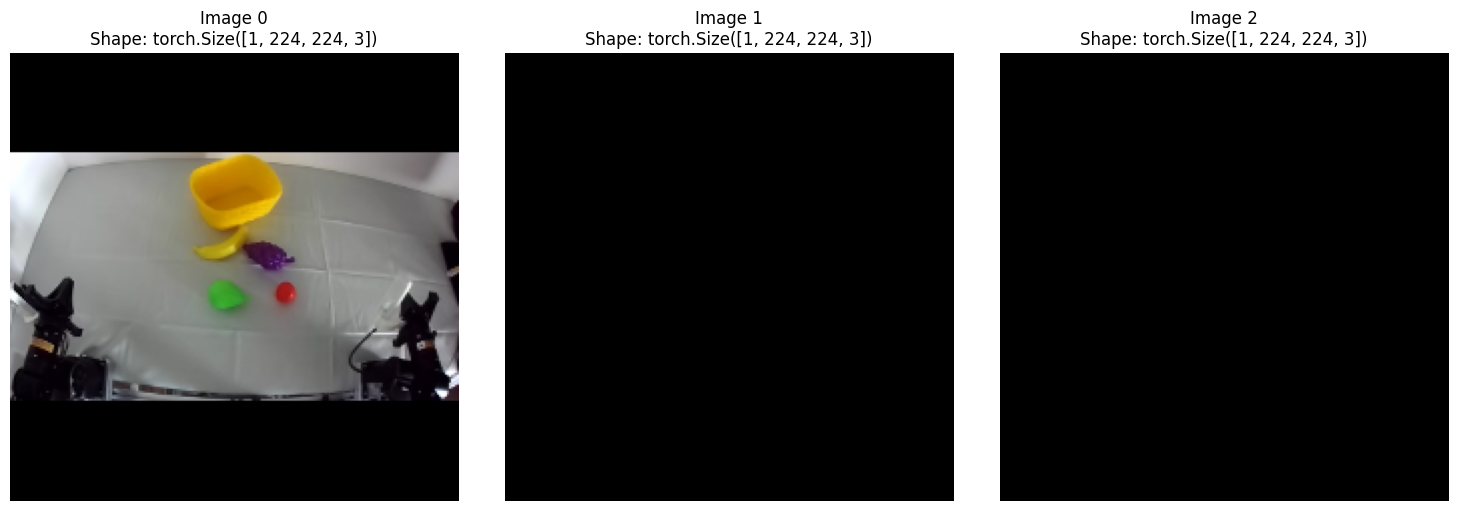

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the processed images
# These images are normalized to [-1, 1] and might be resized

if 'processed_images' in locals():
    num_images = len(processed_images)
    plt.figure(figsize=(5 * num_images, 5))

    for i, img_tensor in enumerate(processed_images):
        # processed_images are typically (B, H, W, C) or (B, C, H, W)
        # We select the first image in the batch
        img = img_tensor[0].detach().cpu().numpy()

        # Check if channels are first (C, H, W) -> convert to (H, W, C) for plotting
        # Heuristic: if first dimension is 3, it's likely channels
        if img.ndim == 3 and img.shape[0] == 3:
             img = np.transpose(img, (1, 2, 0))

        # Un-normalize: [-1, 1] -> [0, 1]
        img = (img + 1.0) / 2.0
        img = np.clip(img, 0.0, 1.0)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i}\nShape: {img_tensor.shape}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("processed_images variable not found.")

In [ ]:
with torch.no_grad():
    # FIX: Ensure images are in (B, C, H, W) format
    # The error "expected input... to have 3 channels, but got 224" occurs because
    # the input was (B, H, W, C) but the model expects (B, C, H, W).
    fixed_processed_images = []
    for img in processed_images:
        # Check if shape is (B, H, W, C=3) instead of (B, C=3, H, W)
        if img.ndim == 4 and img.shape[-1] == 3 and img.shape[1] != 3:
            img = img.permute(0, 3, 1, 2)
        fixed_processed_images.append(img)

    output_tokens, updated_past_key_values = policy.model.sample_low_level_task(
        images=fixed_processed_images,
        img_masks=img_masks,
        tokens=tokens,
        masks=masks.bool(), # FIX: Convert attention mask to boolean
        max_decoding_steps=max_decoding_steps,
        eos_token_id=PALIGEMMA_EOS_TOKEN,
        temperature=temperature
    )

    print(f"Output tokens shape: {output_tokens.shape}")
    print(f"Output tokens:\n{output_tokens}")
    print(f"Updated past key values: {updated_past_key_values}")

    # Decode the generated tokens
    print("\n" + "="*80)
    print("High Level Prompt\n",high_level_prompt)
    print("Decoded output:")
    print("="*80)

    for batch_idx in range(output_tokens.shape[0]):
        batch_tokens = output_tokens[batch_idx]
        # Remove padding (zeros) and decode
        non_zero_tokens = batch_tokens[batch_tokens != 0]
        if len(non_zero_tokens) > 0:
            decoded_text = tokenizer.decode(non_zero_tokens, skip_special_tokens=False)
            print(f"Batch {batch_idx}: {decoded_text}")
        else:
            print(f"Batch {batch_idx}: (empty)")

print("\n" + "="*80)
print("Test completed successfully!")
print("="*80)

Output tokens shape: torch.Size([1, 40])
Output tokens:
tensor([[18075,     1,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
Updated past key values: <transformers.cache_utils.DynamicCache object at 0x7e50cc953080>

High Level Prompt Task: Put the grapes on the basket.
Subtask:

Decoded output:
Batch 0: pick<eos>

Test completed successfully!


# Results

The model don't produce non sense words. But it just produce a word, maybe there is some bug with the EOS token. Or maybe the adaRMS thing. Before make a fine tunning we have to be sure about it.

### Fine-Tuning Example
To fine-tune the model, you need:
1. **Ground Truth Actions**: The actual movements the robot should make.
2. **Training Loop**: A standard PyTorch loop with an optimizer.

The following code demonstrates a single training step using dummy action data.

In [ ]:
import torch.optim as optim
from lerobot.utils.constants import ACTION

# 1. Setup Optimizer
# We fine-tune all parameters here, but you could also freeze specific layers
optimizer = optim.AdamW(policy.parameters(), lr=1e-5)

# 2. Prepare a Training Batch
# We start with the existing batch containing images and text
train_batch = batch.copy()

# We need to add Ground Truth Actions for the loss calculation
# Shape: (Batch_Size, Horizon, Action_Dim)
action_dim = policy.config.max_action_dim
horizon = policy.config.chunk_size
batch_size = 1

# Creating dummy actions (all zeros) for demonstration
# In reality, this would be your recorded robot data
dummy_actions = torch.zeros((batch_size, horizon, action_dim), device=device)
train_batch[ACTION] = dummy_actions

# Optional: Add mask for text loss (if you want to train the VLM part too)
# 1 = Calculate loss for this token, 0 = Ignore
# Typically you mask the prompt and only train on the generated response
train_batch["token_loss_mask"] = torch.ones_like(masks, device=device)

# 3. Run a Training Step
policy.train() # Switch to training mode
optimizer.zero_grad()

# The forward pass automatically calculates the loss
loss, loss_dict = policy(train_batch)

# Backward pass and optimization
loss.backward()
optimizer.step()

print("TRAINING STEP COMPLETE")
print(f"Total Loss: {loss.item():.4f}")
print(f"Detailed Losses: {loss_dict}")

In [ ]:
print("\n" + "="*80)
print("Testing sample_embedding...")
print("="*80)

with torch.no_grad():
    prefix_embeddings, past_key_values, prefix_pad_masks = policy.model.sample_embedding(
        processed_images,
        img_masks,
        tokens,
        masks
    )

    print(f"Prefix embeddings shape: {prefix_embeddings.shape}")
    print(f"Prefix pad masks shape: {prefix_pad_masks.shape}")
    print(f"Past key values type: {type(past_key_values)}")
    if past_key_values is not None:
        print(f"Past key values length: {len(past_key_values)}")
